In [ ]:
import sympy
import numpy as np
import matplotlib.pyplot as plt
from sympy.physics.mechanics import dynamicsymbols, ReferenceFrame
from sympy import symbols
from scipy.optimize import fsolve, minimize

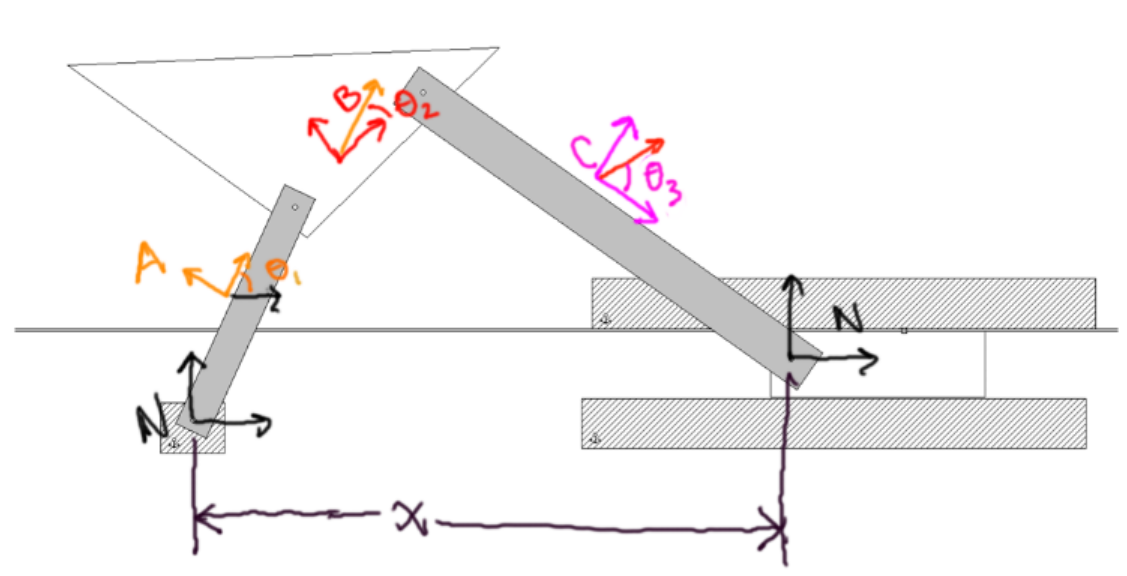

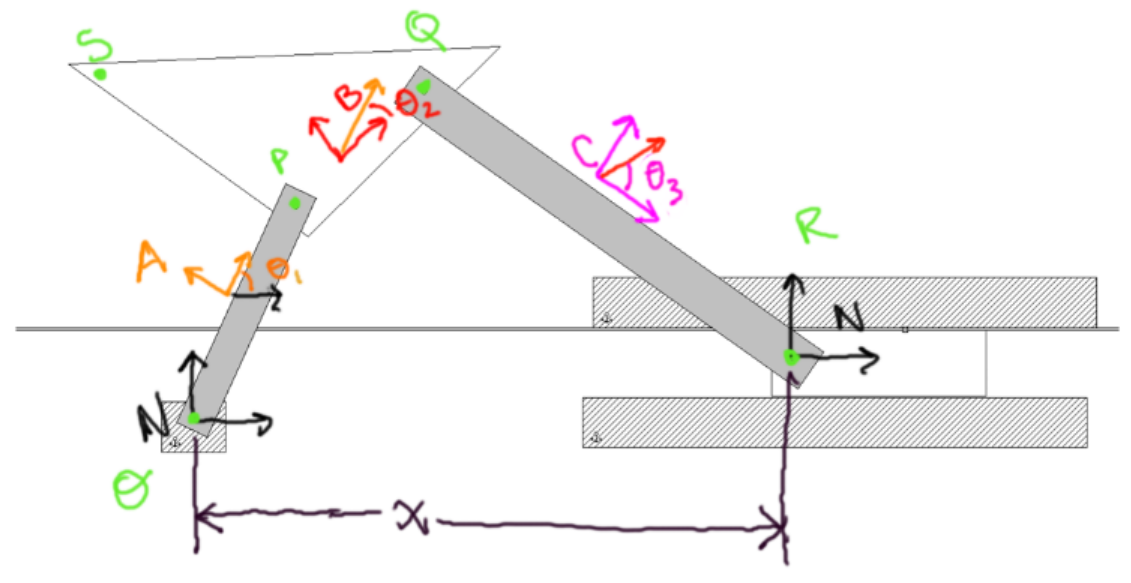

In [ ]:
# Define the dynamic variables
theta1,theta2,theta3,x = dynamicsymbols('theta1 theta2 theta3,x')

# Define the parameters (constants)
OP,PQ,PS,QR,OR_y = symbols('OP PQ PS QR OR_y')
params={OP:0.2,PQ:0.15,PS:0.15,QR:0.6,OR_y:0.05}

# Define the reference frames
N = ReferenceFrame('N')
A= N.orientnew('A','Axis',[theta1,N.z])
B= A.orientnew('B','Axis',[-theta2,N.z])
C= B.orientnew('C','Axis',[-theta3,N.z])

# Define the vector loop
r1=OP*A.x
r2=PQ*B.x
r3=QR*C.x
r4=-x*N.x-OR_y*N.y

# Define the vector loop equation
eq=r1+r2+r3+r4
eq_params=eq.subs(params)
eq_fun=sympy.lambdify([theta1,theta2,theta3,x],[eq_params.dot(N.x),eq_params.dot(N.y)])

eq_params

- x(t)*N.x - 0.05*N.y + 0.2*A.x + 0.15*B.x + 0.6*C.x

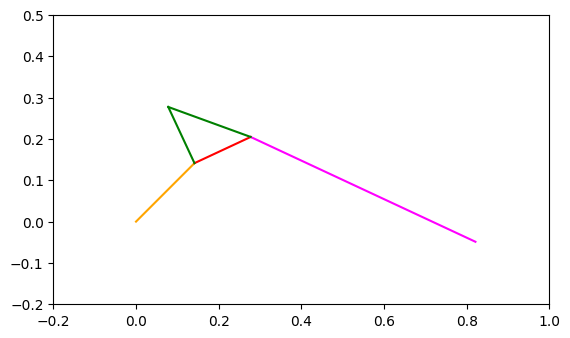

In [4]:
points={'O':0*N.x,'P':r1,'Q':r1+r2,'R':r1+r2+r3,'S':r1+PS*B.y}
points_fun={k:sympy.lambdify([theta1,theta2,theta3,x],[v.dot(N.x).subs(params),v.dot(N.y).subs(params)]) for k,v in points.items()}

def plotMechanism(joint_values,ax=None):    
    O=points_fun['O'](*joint_values)
    P=points_fun['P'](*joint_values)
    Q=points_fun['Q'](*joint_values)
    R=points_fun['R'](*joint_values)
    S=points_fun['S'](*joint_values)
    if ax is None:
        ax=plt.figure().add_subplot(111)
    ax.plot([O[0],P[0]], [O[1],P[1]], 'orange')
    ax.plot([P[0],Q[0]], [P[1],Q[1]], 'red')
    ax.plot([Q[0],R[0]], [Q[1],R[1]], 'magenta')
    ax.plot([P[0],S[0]], [P[1],S[1]], 'green')
    ax.plot([Q[0],S[0]], [Q[1],S[1]], 'green')
    ax.set_aspect('equal')
    ax.set_xlim(-0.2,1.0)
    ax.set_ylim(-0.2,0.5)

# Example with some arbitrary joint values
plotMechanism([np.deg2rad(45),np.deg2rad(20),np.deg2rad(50),0])


## Direct Kinematics

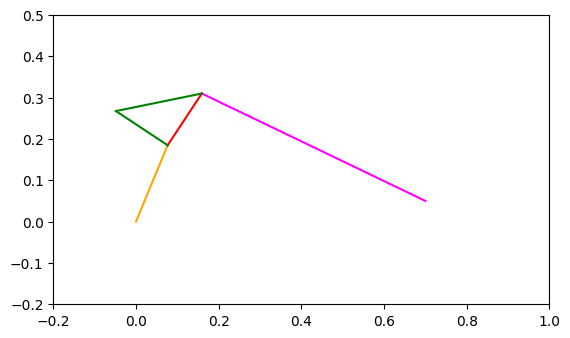

In [5]:
# Solve the vector loop equation for a known theta1 and x.
q_example=[np.deg2rad(67.5),0.70]
fsolve_fun=lambda z: eq_fun(q_example[0],z[0],z[1],q_example[1])
z0=[np.deg2rad(45),np.deg2rad(20)]
out=fsolve(fsolve_fun,z0,full_output=True)
out

plotMechanism([q_example[0],out[0][0],out[0][1],q_example[1]])

In [6]:
# Do this in a loop for the defined functions theta(t) and x(t)
tList=np.linspace(0,10,100)
thetaList=np.deg2rad(67.5+7.5*np.sin(5*tList))
xList=0.70+0.05*np.sin(5*tList)

z0=[np.deg2rad(45),0.70]
zList=[]
for i,ti in enumerate(tList):
    fsolve_fun=lambda z: eq_fun(thetaList[i],z[0],z[1],xList[i])    
    out=fsolve(fsolve_fun,z0,full_output=True)    
    zList.append(out[0])
    z0=out[0]


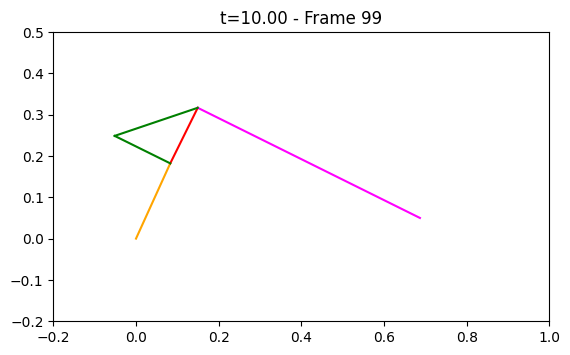

In [253]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig, ax = plt.subplots()

def update(i):
    ax.clear()  # Clear the previous frame
    plotMechanism([thetaList[i], zList[i][0], zList[i][1], xList[i]],ax)
    ax.set_title(f"t={tList[i]:.2f} - Frame {i}")

anim = animation.FuncAnimation(fig, update, frames=len(tList), repeat=False, interval=100)
anim.save("animation_fk.mp4", writer="ffmpeg")  # Install ffmpeg if needed
plt.show()

## Inverse Kinematics

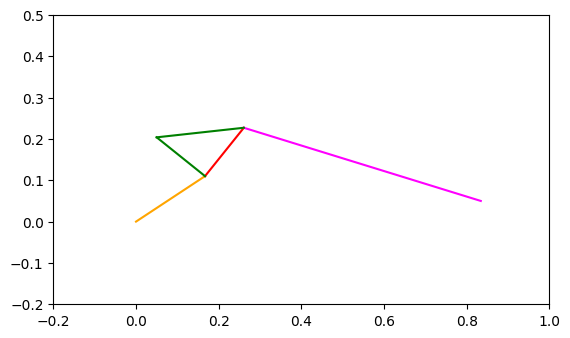

In [27]:
# Solve the vector loop equation for a known position of S.
s_star=np.array([0.05,0.2039127])

# Propose a value for theta1 and x and solve for theta2 and theta3

def FK(q,z0=None):
    fsolve_fun=lambda z: eq_fun(q[0],z[0],z[1],q[1])
    z0=[np.deg2rad(45),np.deg2rad(20)] if z0 is None else z0
    out=fsolve(fsolve_fun,z0,full_output=True)    
    return out[0],out

s_fun=points_fun['S']    
def IK_error(q,s_star):
    z,_=FK(q)        
    s=np.array(s_fun(q[0],z[0],z[1],q[1]))
    er=100*np.square(s-s_star).sum()    
    return er

def IK(s_star):
    q0=[np.deg2rad(64.43),0.70]
    res=minimize(lambda q: IK_error(q,s_star),q0)
    return res.x,res    

qstar,ik_out=IK(s_star)
zstar,fk_out=FK(qstar)
plotMechanism([qstar[0],zstar[0],zstar[1],qstar[1]])

In [29]:
# Do this in a loop for the defined trajectory
thetaList=np.linspace(0,np.pi*2,100)
xList=0.02+0.02*np.cos(thetaList)
yList=0.20+0.02*np.sin(thetaList)

qList=[]
for i,thetai in enumerate(thetaList):
    q,out=IK([xList[i],yList[i]])    
    qList.append(q)

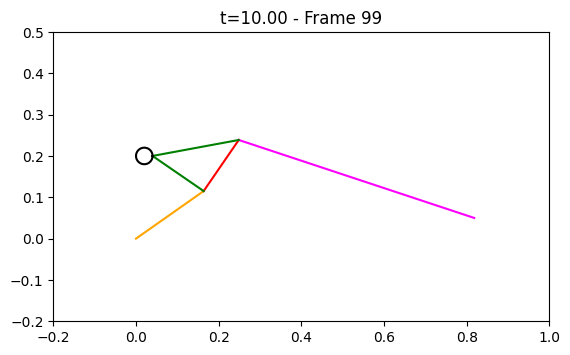

In [28]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig, ax = plt.subplots()

def update(i):
    ax.clear()  # Clear the previous frame
    z=FK(qList[i])[0]
    plotMechanism([qList[i][0], z[0], z[1], qList[i][1]],ax)
    ax.plot(xList[:i],yList[:i],'k')
    ax.set_title(f"t={tList[i]:.2f} - Frame {i}")

anim = animation.FuncAnimation(fig, update, frames=len(tList), repeat=False, interval=100)
anim.save("animation_ik.mp4", writer="ffmpeg")  # Install ffmpeg if needed
plt.show()